In [1]:
import h5py
import time
import argparse
import numpy as np
import scipy.io as sio
from copy import deepcopy
from einops import rearrange
import matplotlib.pyplot as plt
from torch.nn.modules.loss import _Loss

import torch
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
from torchsummary import summary
import torch.backends.cudnn as cudnn

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

from data_prepare import mirror_hsi
from data_prepare import choose_train_and_test_number
from data_prepare import choose_train_and_test_proportion
from data_prepare import train_and_test_data, train_and_test_label

from Utils import ActivationOutputData
from Utils import AverageMeter, accuracy
from Utils import output_metric, plot_confusion_matrix
from Utils import train_epoch, test_epoch, valid_epoch
from Utils import list_to_colormap, classification_map, print_args

from datetime import datetime
import math
from operator import truediv
import os
import pickle

%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("Caps-Transformer")
parser.add_argument('--dataset', choices=['Chikusei', 'Pavia', 'KSC', 'HU2013'], default='KSC', help='dataset to use')
parser.add_argument('--flag_test', choices=['test', 'train'], default='train', help='testing mark')
parser.add_argument('--gpu_id', default='0', help='GPU id')
parser.add_argument('--seed', type=int, default=0, help='number of seed')
parser.add_argument('--batch_size', type=int, default=32, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=25, help='size of patches')
parser.add_argument('--epoches', type=int, default=50, help='epoch number')
parser.add_argument('--weight_decay', type=float, default=2e-7, help='weight_decay')
parser.add_argument('--learning_rate', type=float, default=3e-3, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--train_number', type=int, default=1, help='num_train_per_class')
parser.add_argument('--train_proportion', type=float, default=0.1, help='num_train_per_class')
args = parser.parse_args(args=[])

In [3]:
# prepare data
if args.dataset == 'Chikusei':
    data = h5py.File('./dataset/Chikusei.mat', 'r')['chikusei']
    data = np.array(data)
    data = np.transpose(data, (2, 1, 0))
    label = sio.loadmat('./dataset/Chikusei_gt.mat')['GT'][0][0][0]
elif args.dataset == 'HU2013':
    data = sio.loadmat('./dataset/Houston.mat')['Houston']
    label = sio.loadmat('./dataset/Houston_gt.mat')['Houston_gt']
elif args.dataset == 'Pavia':
    data = sio.loadmat('./dataset/PaviaU.mat')['paviaU']
    label = sio.loadmat('./dataset/PaviaU_gt.mat')['paviaU_gt']
elif args.dataset == 'KSC':
    data = sio.loadmat('./dataset/KSC.mat')['KSC']
    label = sio.loadmat('./dataset/KSC_gt.mat')['KSC_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 13


In [4]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [5]:
total_pos_train, total_pos_test, total_pos_true, number_train, number_test, number_true = \
choose_train_and_test_proportion(label, args.train_proportion)
#  Don't forget to modify the choose_train_and_test_proportion function in the data_prepare module.

In [6]:
def applyPCA(X, numComponents=30):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX, pca

In [ ]:
K = 30
data, pca = applyPCA(data, numComponents=K)
np.save('./dataset/KSC_PCA.npy', data)

In [7]:
data = np.load('./dataset/KSC_PCA.npy')

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=512, width=614, band=30


In [8]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

x_train, x_test, x_true = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, 
                                              total_pos_true, patch_size=args.patch_size)

y_train, y_test, y_true = train_and_test_label(number_train, number_test, number_true, num_classes)

**************************************************
patch_size is : 25
mirror_data shape : [536, 638, 30]
**************************************************
x_train shape = (528, 25, 25, 30), type = float64
x_test  shape = (4683, 25, 25, 30), type = float64
x_true  shape = (5211, 25, 25, 30), type = float64
**************************************************
y_train: shape = (528,), type = int64
y_test: shape = (4683,), type = int64
y_true: shape = (5211,), type = int64
**************************************************


In [9]:
# load data
x_train = torch.from_numpy(x_train.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (13, 176, 7, 7)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
Train_Label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5198, 176, 7, 7)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
Test_Label = Data.TensorDataset(x_test, y_test)

x_true = torch.from_numpy(x_true.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5211, 176, 7, 7)
print(x_true.shape)
y_true = torch.from_numpy(y_true).type(torch.LongTensor)
True_Label = Data.TensorDataset(x_true, y_true)

train_loader = Data.DataLoader(Train_Label, batch_size=args.batch_size, shuffle=True)
test_loader = Data.DataLoader(Test_Label, batch_size=args.batch_size, shuffle=False)
true_loader = Data.DataLoader(True_Label, batch_size=100, shuffle=False)

torch.Size([528, 30, 25, 25])
torch.Size([4683, 30, 25, 25])
torch.Size([5211, 30, 25, 25])


## **Model**

#### Capsule Network Model

In [10]:
class PrimaryCaps(nn.Module):
    
    def __init__(self, A=64, B=32, K=1, P=4, stride=1):
        super(PrimaryCaps, self).__init__()
        self.pose = nn.Conv2d(in_channels=A, out_channels=B*P*P,
                            kernel_size=K, stride=stride, bias=True)
        self.a = nn.Conv2d(in_channels=A, out_channels=B,
                            kernel_size=K, stride=stride, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        p = self.pose(x)  # (batch, 32x4x4, 13, 13)
        a = self.a(x)  # (batch, 32, 13, 13)
        a = self.sigmoid(a)
        out = torch.cat([p, a], dim=1)
        out = out.permute(0, 2, 3, 1)
        return out  # (batch, 13, 13, 544)

In [11]:
class ConvCaps(nn.Module):

    def __init__(self, B=32, C=16, K=3, P=4, stride=2, iters=3, coor_add=False, w_shared=False):
        super(ConvCaps, self).__init__()
        self.B = B
        self.C = C
        self.K = K
        self.P = P
        self.psize = P*P  # 16
        self.stride = stride  # 2
        self.iters = iters
        self.coor_add = coor_add
        self.w_shared = w_shared
        self.eps = 1e-8
        self._lambda = 1e-03
        self.ln_2pi = torch.cuda.FloatTensor(1).fill_(math.log(2*math.pi))  # tensor([1.8379])

        self.beta_u = nn.Parameter(torch.zeros(C))  # tensor([0, 0, ...,0])
        self.beta_a = nn.Parameter(torch.zeros(C))

        self.weights = nn.Parameter(torch.randn(1, K*K*B, C, P, P))  # (1, 3x3x32, 16, 4, 4) 类似胶囊网络中的权重 or (1, 1x1x16, 16, 4, 4)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=2)

    def m_step(self, a_in, r, v, eps, b, B, C, psize):
        # v: (batchx6x6, 3x3x32, 16, 16)
        r = r * a_in  # (batchx6x6, 3x3x32, 16) 这里的16表示每个位置的父胶囊的个数
        r = r / (r.sum(dim=2, keepdim=True) + eps)  # (batchx6x6, 3x3x32, 16) 这一步的目的是使r重新表示成概率(和为1)
        r_sum = r.sum(dim=1, keepdim=True)  # (batchx6x6, 1, 16) 这里的3x3x32可以看作巻积胶囊层中初级胶囊的个数
        coeff = r / (r_sum + eps)  # (batchx6x6, 3x3x32, 16)
        coeff = coeff.view(b, B, C, 1)  # (batchx6x6, 3x3x32, 16, 1)

        mu = torch.sum(coeff * v, dim=1, keepdim=True)  # (batchx6x6, 1, 16, 16)
        # 这里的代码实现先计算了一个coeff，对应M-Step中的第二步，并没有错哦，只是有点儿巧妙
        sigma_sq = torch.sum(coeff * (v - mu)**2, dim=1, keepdim=True) + eps  # (batchx6x6, 1, 16, 16)

        r_sum = r_sum.view(b, C, 1)  # (batchx6x6, 16, 1)
        sigma_sq = sigma_sq.view(b, C, psize)  # (batchx6x6, 16, 16)
        cost_h = (self.beta_u.view(C, 1) + torch.log(sigma_sq.sqrt())) * r_sum  # (batchx6x6, 16, 16)

        a_out = self.sigmoid(self._lambda*(self.beta_a - cost_h.sum(dim=2))) # cost_h.sum(dim=2)表示对每个父胶囊在特征维度求和 (batchx6x6, 16)
        sigma_sq = sigma_sq.view(b, 1, C, psize)  # (batchx6x6, 1, 16, 16)

        return a_out, mu, sigma_sq  # (batchx6x6, 16), (batchx6x6, 1, 16, 16), (batchx6x6, 1, 16, 16) 父胶囊激活，父胶囊分布的均值，父胶囊分布的方差

    def e_step(self, mu, sigma_sq, a_out, v, eps, b, C):
        # v: (batchx6x6, 3x3x32, 16, 16)
        ln_p_j_h = -1. * (v - mu)**2 / (2 * sigma_sq) - torch.log(sigma_sq.sqrt()) - 0.5*self.ln_2pi  # 太过于精彩!!!!!看到这里你豁然开朗了吗？？？
        # 这一步在计算所有初级胶囊的投票与父胶囊分布的均值之间的相似性，根据这个相似性来重新计算概率分配，你，懂了吗？？？ (batchx6x6, 3x3x32, 16, 16)
        ln_ap = ln_p_j_h.sum(dim=3) + torch.log(a_out.view(b, 1, C))  # 那既然对p_j_h求对数了，也要对a求对数  (batchx6x6, 3x3x32, 16)
        r = self.softmax(ln_ap)  # 重新计算的概率分配 (batchx6x6, 3x3x32, 16)
        return r

    def caps_em_routing(self, v, a_in, C, eps):

        b, B, c, psize = v.shape  # (batchx6x6, 3x3x32, 16, 16)
        assert c == C
        assert (b, B, 1) == a_in.shape  # (batchx6x6, 3x3x32, 1)

        r = torch.cuda.FloatTensor(b, B, C).fill_(1./C)  # (batchx6x6, 3x3x32, 16) 分配概率rij(和为1)
        for iter_ in range(self.iters):
            a_out, mu, sigma_sq = self.m_step(a_in, r, v, eps, b, B, C, psize)
            # (batchx6x6, 16), (batchx6x6, 1, 16, 16), (batchx6x6, 1, 16, 16) 父胶囊激活，父胶囊分布的均值，父胶囊分布的方差
            if iter_ < self.iters - 1:
                r = self.e_step(mu, sigma_sq, a_out, v, eps, b, C)

        return mu, a_out  # 返回父胶囊分布的均值(batchx6x6, 1, 16, 16)和父胶囊的激活(batchx6x6, 16)

    def add_pathes(self, x, B, K, psize, stride): 

        b, h, w, c = x.shape  # batch, 13, 13, 544
        assert h == w
        assert c == B*(psize+1)
        oh = ow = int(((h - K )/stride)+ 1)  # 6 
        idxs = [[(h_idx + k_idx) for k_idx in range(0, K)] for h_idx in range(0, h - K + 1, stride)]
        x = x[:, idxs, :, :]  # (batch, 6, 3, 13, 544)
        x = x[:, :, :, idxs, :]  # (batch, 6, 3, 6, 3, 544)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()  # (batch, 6, 6, 3, 3, 544)
        return x, oh, ow  # (batch, 6, 6, 3, 3, 544), 6, 6

    def transform_view(self, x, w, C, P, w_shared=False):

        b, B, psize = x.shape  # (batchx6x6, 3x3x32, 16) or (batch, 4x4x16, 16) when stride=1
        assert psize == P*P

        x = x.view(b, B, 1, P, P)  # (batchx6x6, 3x3x32, 1, 4, 4) or (batch, 4x4x16, 1, 4, 4) 
        if w_shared:
            hw = int(B / w.size(1))  # int(4x4x16 / 1x1x16) = 4x4
            w = w.repeat(1, hw, 1, 1, 1)  # (1, 4x4x16, 16, 4, 4)

        w = w.repeat(b, 1, 1, 1, 1)  # (batchx6x6, 3x3x32, 16, 4, 4) or (batch, 4x4x16, 16, 4, 4)
        x = x.repeat(1, 1, C, 1, 1)  # (batchx6x6, 3x3x32, 16, 4, 4) or (batch, 4x4x16, 16, 4, 4)
        v = torch.matmul(x, w)
        v = v.view(b, B, C, P*P)  # (batchx6x6, 3x3x32, 16, 16) 所有初级胶囊i对于所有胶囊j的投票结果 or (batch, 4x4x16, 16, 16)
        return v

    def add_coord(self, v, b, h, w, B, C, psize):
        # v: (batch, 4x4x16, 16, 16)
        assert h == w
        v = v.view(b, h, w, B, C, psize)  # (batch, 4, 4, 16, 16, 16)
        coor = torch.arange(h, dtype=torch.float32) / h
        coor_h = torch.cuda.FloatTensor(1, h, 1, 1, 1, self.psize).fill_(0.)  # (1, 4, 1, 1, 1, 16)
        coor_w = torch.cuda.FloatTensor(1, 1, w, 1, 1, self.psize).fill_(0.)  # (1, 1, 4, 1, 1, 16)
        coor_h[0, :, 0, 0, 0, 0] = coor
        coor_w[0, 0, :, 0, 0, 1] = coor
        v = v + coor_h + coor_w  # 添加坐标是否可以理解为添加位置信息？？？？？？？？？？？
        v = v.view(b, h*w*B, C, psize)  # (batch, 4x4x16, 16, 16)
        return v

    def forward(self, x):
        b, h, w, c = x.shape  # (batch, 13, 13, 544)
        if not self.w_shared:
            x, oh, ow = self.add_pathes(x, self.B, self.K, self.psize, self.stride) #  (batch, 6, 6, 3, 3, 544), 6, 6

            p_in = x[:, :, :, :, :, :self.B*self.psize].contiguous()  # (batch, 6, 6, 3, 3, 512)
            a_in = x[:, :, :, :, :, self.B*self.psize:].contiguous()  # (batch, 6, 6, 3, 3, 32)
            p_in = p_in.view(b*oh*ow, self.K*self.K*self.B, self.psize)  # (batchx6x6, 3x3x32, 16) 这里的3x3x32可以看作巻积胶囊层中初级胶囊的个数
            a_in = a_in.view(b*oh*ow, self.K*self.K*self.B, 1)  # (batchx6x6, 3x3x32, 1)
            v = self.transform_view(p_in, self.weights, self.C, self.P)  # (batchx6x6, 3x3x32, 16, 16) 初级胶囊对父胶囊的投票

            p_out, a_out = self.caps_em_routing(v, a_in, self.C, self.eps) # 返回父胶囊分布的均值(batchx6x6, 1, 16, 16)和父胶囊的激活(batchx6x6, 16)
            p_out = p_out.view(b, oh, ow, self.C*self.psize)  # （batch, 6, 6, 16x16）
            a_out = a_out.view(b, oh, ow, self.C)  # (batch, 6, 6, 16)
            out = torch.cat([p_out, a_out], dim=3) # (batch, 6, 6, (16+1)x16)
        else:
            # x: (batch, 4, 4, (16+1)x16)
            assert c == self.B*(self.psize+1)
            assert 1 == self.K
            assert 1 == self.stride
            p_in = x[:, :, :, :self.B*self.psize].contiguous() # (batch, 4, 4, 16x16)
            p_in = p_in.view(b, h*w*self.B, self.psize)  # (batch, 4x4x16, 16)
            a_in = x[:, :, :, self.B*self.psize:].contiguous()  # (batch, 4, 4, 16)
            a_in = a_in.view(b, h*w*self.B, 1)  # (batch, 4x4x16, 1)

            v = self.transform_view(p_in, self.weights, self.C, self.P, self.w_shared)  # (batch, 4x4x16, 16, 16)

            if self.coor_add:
                v = self.add_coord(v, b, h, w, self.B, self.C, self.psize)

            _, out = self.caps_em_routing(v, a_in, self.C, self.eps)  # 返回父胶囊的激活(batch, 16)

        return out

In [12]:
class CapsNet(nn.Module):

    def __init__(self, A=64, B=32, C=16, D=16, E=16, K=3, P=4, iters=3, pca_components=30):
        super(CapsNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=pca_components, out_channels=A,
                               kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=A, eps=0.001,
                                 momentum=0.1, affine=True)
        self.relu1 = nn.ReLU(inplace=False)
        self.primary_caps = PrimaryCaps(A, B, 1, P, stride=1)
        self.conv_caps1 = ConvCaps(B, C, K, P, stride=2, iters=iters)
        self.conv_caps2 = ConvCaps(C, D, K, P, stride=1, iters=iters)
        self.class_caps = ConvCaps(D, E, 1, P, stride=1, iters=iters,
                                        coor_add=True, w_shared=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.primary_caps(x) # (batch, 13, 13, 544)
        x = self.conv_caps1(x)  # (batch, 6, 6, (16+1)x16)
        x = self.conv_caps2(x)  # (batch, 4, 4, (16+1)x16)
        x = self.class_caps(x)  # (batch, 16)
        return x

#### Loss Function

In [13]:
class SpreadLoss(_Loss):

    def __init__(self, m_min=0.2, m_max=0.9, num_class=16):
        super(SpreadLoss, self).__init__()
        self.m_min = m_min
        self.m_max = m_max
        self.num_class = num_class

    def forward(self, x, target, r):
        b, E = x.shape  # batch, 16
        assert E == self.num_class
        margin = self.m_min + (self.m_max - self.m_min)*r  # 0.2 + (0.5 - 0.2) * r

        at = torch.cuda.FloatTensor(b).fill_(0)  # (batch, )
        for i, a in enumerate(target):
            lb = int(a.item())  # 真实标签，整数值，并不是one-hot
            at[i] = x[i][lb]  # 对应真实标签的类别胶囊激活值
        at = at.view(b, 1).repeat(1, E)  # (batch, 16)

        zeros = x.new_zeros(x.shape)  # (batch, 16)
        loss = torch.max(margin - (at - x), zeros)  # (batch, 16)
        loss = loss**2
        loss = loss.sum() / b - margin**2 

        return loss

## **Training Setup**

#### Accuracy Function

#### Train Function

In [14]:
def exp_lr_decay(optimizer, global_step, init_lr = 3e-3, decay_steps = 20000,
                                        decay_rate = 0.96, lr_clip = 3e-3 ,staircase=False):
        
    if staircase:
        lr = (init_lr * decay_rate**(global_step // decay_steps)) 
    else:
        lr = (init_lr * decay_rate**(global_step / decay_steps)) 
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [15]:
# train model
def train(model, train_loader, criterion, optimizer, epoch):
    objs = AverageMeter()
    top1 = AverageMeter()
    tar = np.array([])
    pre = np.array([])
    train_len = len(train_loader)
    
    for batch_idx, (batch_data, batch_target) in enumerate(train_loader):
        batch_data = batch_data.cuda()
        batch_target = batch_target.cuda()   
        
        optimizer.zero_grad()
        batch_pred = model(batch_data)  # (batch, 13)
        
        r = (1.*batch_idx + (epoch-1)*train_len) / (epoch*train_len)  # 表示当前训练轮次的训练数据的进度条
        loss = criterion(batch_pred, batch_target, r)
        
        global_step = (batch_idx+1) + (epoch - 1) * len(train_loader) 
        exp_lr_decay(optimizer=optimizer, global_step=global_step)
        
        loss.backward()
        optimizer.step()
        
        prec1, t, p = accuracy(batch_pred, batch_target, topk=(1,))
        n = batch_data.shape[0]
        objs.update(loss.data, n)  # 计算所有训练样本的平均损失
        top1.update(prec1[0].data, n)  # 计算所有训练样本的平均准确率
        tar = np.append(tar, t.data.cpu().numpy())
        pre = np.append(pre, p.data.cpu().numpy())
    return top1.avg, objs.avg, tar, pre

#### Test Function

In [16]:
# test model
def test(model, test_loader):
    tar = np.array([])
    pre = np.array([])
    with torch.no_grad():
        for batch_idx, (batch_data, batch_target) in enumerate(test_loader):
            batch_data = batch_data.cuda()
            batch_target = batch_target.cuda()
            
            batch_pred = model(batch_data)  # (batch, 13)
            _, pred = batch_pred.topk(1, axis=1)  # (100, 1)
            pp = pred.squeeze()  # (100, )
            
            tar = np.append(tar, batch_target.data.cpu().numpy())
            pre = np.append(pre, pp.data.cpu().numpy())
    return tar, pre


def valid(model, true_loader):
    pre = np.array([])
    for batch_idx, (batch_data, batch_target) in enumerate(true_loader):
        batch_data = batch_data.cuda()
        batch_target = batch_target.cuda()
        
        batch_pred = model(batch_data)  # (100, 13)
        _, pred = batch_pred.topk(1, axis=1)  # (100, 1)
        pp = pred.squeeze()  # (100, )
        pre = np.append(pre, pp.data.cpu().numpy())
    return pre  # (100, )

## **Training Process**

#### Model Initialization

In [17]:
model = CapsNet(A=64, B=32, C=16, D=16, E=num_classes, iters=2).cuda()
criterion = SpreadLoss(num_class=num_classes, m_min=0.2, m_max=0.5)
optimizer = optim.Adam(model.parameters(), lr = args.learning_rate, weight_decay=args.weight_decay)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)

In [18]:
tic = time.time()

for epoch in range(1, args.epoches+1):
    # train model
    model.train()
    # 计算的是移动平均准确率
    train_acc, train_obj, tar_train, pre_train = train(model, train_loader, criterion, optimizer, epoch)
    OA_trian, AA_mean_train, Kappa_train, AA_train = output_metric(tar_train, pre_train)
    print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}".format(epoch, train_obj, train_acc))
    #scheduler.step()
    
toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

Epoch: 001 train_loss: 0.7997 train_acc: 46.5909
Epoch: 002 train_loss: 0.6925 train_acc: 69.6970
Epoch: 003 train_loss: 0.5425 train_acc: 78.5985
Epoch: 004 train_loss: 0.4065 train_acc: 87.8788
Epoch: 005 train_loss: 0.3240 train_acc: 91.0985
Epoch: 006 train_loss: 0.2787 train_acc: 92.4242
Epoch: 007 train_loss: 0.2341 train_acc: 92.0455
Epoch: 008 train_loss: 0.2010 train_acc: 93.5606
Epoch: 009 train_loss: 0.1770 train_acc: 94.3182
Epoch: 010 train_loss: 0.1535 train_acc: 94.1288
Epoch: 011 train_loss: 0.1342 train_acc: 95.4546
Epoch: 012 train_loss: 0.1471 train_acc: 93.9394
Epoch: 013 train_loss: 0.1317 train_acc: 96.5909
Epoch: 014 train_loss: 0.1071 train_acc: 96.9697
Epoch: 015 train_loss: 0.1071 train_acc: 96.4015
Epoch: 016 train_loss: 0.0951 train_acc: 96.9697
Epoch: 017 train_loss: 0.0816 train_acc: 96.0227
Epoch: 018 train_loss: 0.0762 train_acc: 98.1061
Epoch: 019 train_loss: 0.0621 train_acc: 98.8636
Epoch: 020 train_loss: 0.0637 train_acc: 98.6742
Epoch: 021 train_los

#### Testing time!

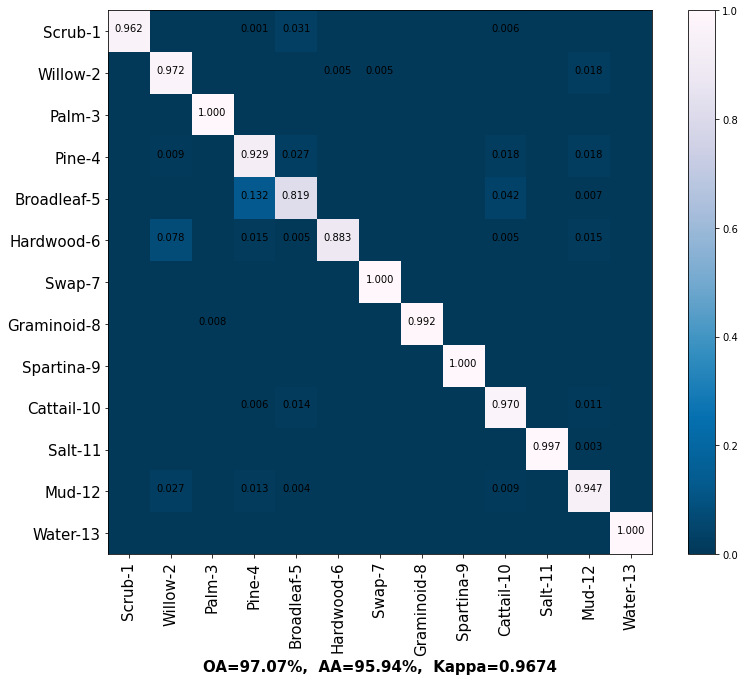

**************************************************
Final result:
OA: 97.07% | AA: 95.94% | Kappa: 0.9674
[0.9619883  0.97247706 1.         0.92920354 0.81944444 0.88349515
 1.         0.99224806 1.         0.96969697 0.99734748 0.94690265
 1.        ]
**************************************************
Parameter:
dataset: KSC
flag_test: train
gpu_id: 0
seed: 0
batch_size: 32
patch_size: 25
epoches: 50
weight_decay: 2e-07
learning_rate: 0.003
gamma: 0.99
train_number: 1
train_proportion: 0.1
**************************************************


In [19]:
model.eval()
tar_test, pre_test = test(model, test_loader)  # 收集所有真实标签和预测标签(np.array)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)

# output classification maps
#pre_u = valid(net, true_loader)
#prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
#for i in range(total_pos_true.shape[0]):
#    prediction_matrix[total_pos_true[i, 0], total_pos_true[i, 1]] = pre_u[i] + 1
cm = confusion_matrix(tar_test, pre_test)
plot_confusion_matrix(args.dataset, cm, path='./Confusion_DMC.pdf')

print("**************************************************")
print("Final result:")
print("OA: {:.2f}% | AA: {:.2f}% | Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print(AA_test)
print("**************************************************")
print("Parameter:")
print_args(vars(args))
print("**************************************************")

In [20]:
average_accuracy = str(list(np.around(AA_test, 7)))
file_name = "./CR/DM-Capsnet_1.txt"

with open(file_name, 'w') as x_file:
    x_file.write("[{:.5f}, {:.5f}, {:.7f}]".format(OA_test * 100., AA_mean_test*100., Kappa_test))
    x_file.write('\n')
    x_file.write('{}'.format(average_accuracy))